In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [3]:
url = 'https://www.alphavantage.co/query'
params = {
    'function': 'TIME_SERIES_DAILY',
    'symbol': 'TSLA',
    'outputsize': 'full',
    'apikey': '1SSTSA3XGLWFQLCA'
}

response = requests.get(url, params=params)
# extract the json from the response without the headers and convert it to a dictionary also remove the meta data
data = response.json()['Time Series (Daily)']

In [50]:
# convert the dictionary to a dataframe using
df = pd.read_csv('TSLA.csv')

training_set = df.iloc[:, 1:2].values

print(df.head())

         Date    Open      High       Low   Close     Volume
0  2023-10-16  250.05  255.3999  248.4800  253.92   88917176
1  2023-10-13  258.90  259.6000  250.2200  251.12  102296786
2  2023-10-12  262.92  265.4100  256.6307  258.87  111508114
3  2023-10-11  266.20  268.6000  260.9000  262.99  103706266
4  2023-10-10  257.75  268.9400  257.6500  263.62  122656030


In [51]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))

training_set_scaled = sc.fit_transform(training_set)

# print the first 5 rows of the scaled training set
print(training_set_scaled)

[[0.10263802]
 [0.10652134]
 [0.10828529]
 ...
 [0.0038877 ]
 [0.00423435]
 [0.00125495]]


In [52]:
X_train = []
y_train = []
for i in range(60, 3340):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [53]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [54]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
103/103 [==============================] - 7s 19ms/step - loss: 0.0040
Epoch 2/100
103/103 [==============================] - 2s 16ms/step - loss: 0.0023
Epoch 3/100
103/103 [==============================] - 2s 16ms/step - loss: 0.0021
Epoch 4/100
103/103 [==============================] - 2s 16ms/step - loss: 0.0017
Epoch 5/100
103/103 [==============================] - 2s 16ms/step - loss: 0.0016
Epoch 6/100
103/103 [==============================] - 2s 16ms/step - loss: 0.0013
Epoch 7/100
103/103 [==============================] - 2s 15ms/step - loss: 0.0012
Epoch 8/100
103/103 [==============================] - 2s 16ms/step - loss: 0.0012
Epoch 9/100
103/103 [==============================] - 2s 15ms/step - loss: 9.9870e-04
Epoch 10/100
103/103 [==============================] - 2s 16ms/step - loss: 8.6734e-04
Epoch 11/100
103/103 [==============================] - 2s 16ms/step - loss: 8.7529e-04
Epoch 12/100
103/103 [==============================] - 2s 16ms/step - lo

In [55]:
#read only the last 10 days of the stock price
dataset_test = pd.read_csv('TSLAREAL.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [56]:
dataset_total = pd.concat((df['Open'], dataset_test['Open']), axis = 0)
# get the inputs for the test data
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 1s 603ms/step


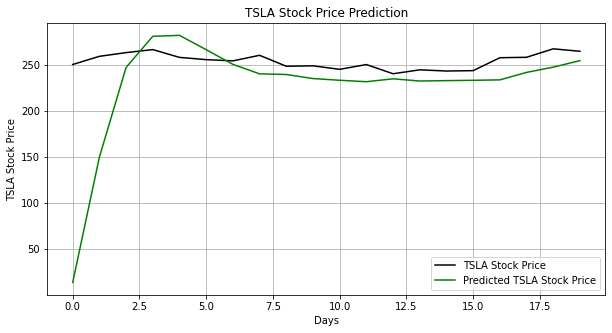

29.310171615219122
    Predicted Stock Price  Real Stock Price
0               13.912702           250.050
1              149.673813           258.900
2              246.871796           262.920
3              280.608063           266.200
4              281.622345           257.750
5              266.096802           255.310
6              250.212418           253.980
7              239.927505           260.000
8              239.208023           248.140
9              234.822342           248.610
10             232.947464           244.810
11             231.409439           250.000
12             234.518600           240.020
13             232.153427           244.262
14             232.571625           242.980
15             232.930618           243.380
16             233.388718           257.400
17             241.495773           257.850
18             247.161514           267.040
19             254.234955           264.350


In [57]:
# Visualising the results
plt.plot(real_stock_price, color = 'black', label = 'TSLA Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted TSLA Stock Price')
#make the plot look better
plt.rcParams['figure.figsize'] = [10, 5]
plt.grid(True)
plt.title('TSLA Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('TSLA Stock Price')
plt.legend()
plt.show()

# convert the results to a dataframe
result_df = pd.DataFrame(predicted_stock_price, columns=['Predicted Stock Price'])

#convert the real stock price to a dataframe
real_stock_price_df = pd.DataFrame(real_stock_price, columns=['Real Stock Price'])

#calculate the average error of the prediction
error = 0
for i in range(0, len(real_stock_price_df)-1):
    error += abs(real_stock_price_df.iloc[i,0] - result_df.iloc[i,0])
error = error / len(real_stock_price_df)
print(error)

df3 = pd.concat([result_df, real_stock_price_df], axis=1)
print(df3)

In [14]:
#Start another training session with the data from APPL.csv
df = pd.read_csv('AAPL.csv')
training_set = df.iloc[:, 1:2].values

print(df.head())
#scale the data
training_set_scaled = sc.fit_transform(training_set)

# shape the data
X_train = []
y_train = []
for i in range(60, 6029):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
# reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

         Date     Open     High     Low   Close    Volume
0  2023-10-17  176.645  178.420  174.80  177.15  57417681
1  2023-10-16  176.750  179.075  176.51  178.72  52516984
2  2023-10-13  181.420  181.930  178.14  178.85  51456082
3  2023-10-12  180.070  182.340  179.04  180.71  56743119
4  2023-10-11  178.200  179.850  177.60  179.80  47551098


In [15]:
# create the model
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
# Adding the output layer
regressor.add(Dense(units = 1))

# compile the model
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# fit the model
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
187/187 [==============================] - 7s 17ms/step - loss: 0.0061
Epoch 2/100
187/187 [==============================] - 3s 17ms/step - loss: 0.0026
Epoch 3/100
187/187 [==============================] - 3s 18ms/step - loss: 0.0022
Epoch 4/100
187/187 [==============================] - 3s 18ms/step - loss: 0.0019
Epoch 5/100
187/187 [==============================] - 3s 18ms/step - loss: 0.0017
Epoch 6/100
187/187 [==============================] - 4s 20ms/step - loss: 0.0016
Epoch 7/100
187/187 [==============================] - 4s 19ms/step - loss: 0.0014
Epoch 8/100
187/187 [==============================] - 3s 18ms/step - loss: 0.0013
Epoch 9/100
187/187 [==============================] - 3s 18ms/step - loss: 0.0012
Epoch 10/100
187/187 [==============================] - 4s 20ms/step - loss: 0.0012
Epoch 11/100
187/187 [==============================] - 3s 17ms/step - loss: 0.0012
Epoch 12/100
187/187 [==============================] - 3s 18ms/step - loss: 0.0011
E

In [30]:
#read only the last 10 days of the stock price
dataset_test = pd.read_csv('AAPLREAL.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values
dataset_total = pd.concat((df['Open'], dataset_test['Open']), axis = 0)
# get the inputs for the test data
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 0s 41ms/step


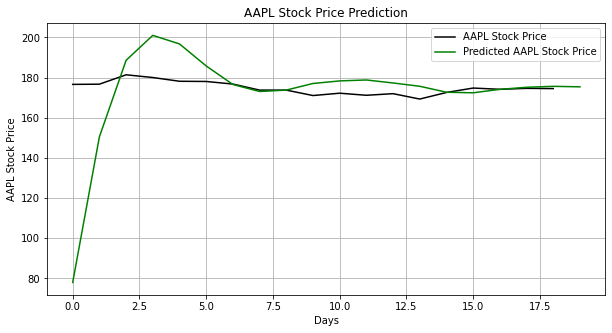

11.367660506399057
    Predicted Stock Price  Real Stock Price
0               77.996605           176.645
1              150.494034           176.750
2              188.637466           181.420
3              201.068024           180.070
4              196.802185           178.200
5              185.828308           178.100
6              176.605362           176.810
7              173.105988           173.800
8              173.800964           173.790
9              177.095856           171.090
10             178.382385           172.255
11             178.842194           171.220
12             177.343811           172.020
13             175.707642           169.340
14             172.741531           172.620
15             172.451828           174.820
16             174.176926           174.200
17             175.205139           174.670
18             175.680786           174.550
19             175.428711               NaN


In [31]:
# Visualising the results
plt.plot(real_stock_price, color = 'black', label = 'AAPL Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted AAPL Stock Price')
#make the plot look better
plt.rcParams['figure.figsize'] = [10, 5]
plt.grid(True)
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()

# convert the results to a dataframe
result_df = pd.DataFrame(predicted_stock_price, columns=['Predicted Stock Price'])

#convert the real stock price to a dataframe
real_stock_price_df = pd.DataFrame(real_stock_price, columns=['Real Stock Price'])

#calculate the average error of the prediction
error = 0
for i in range(0, len(real_stock_price_df)):
    error += abs(real_stock_price_df.iloc[i,0] - result_df.iloc[i,0])
error = error / len(real_stock_price_df)
print(error)

df3 = pd.concat([result_df, real_stock_price_df], axis=1)
print(df3)

In [34]:
#Start another training session with the data from NFLX.csv
df = pd.read_csv('NFLX.csv')
training_set = df.iloc[:, 1:2].values

print(df.head())
#scale the data
training_set_scaled = sc.fit_transform(training_set)

# shape the data
X_train = []
y_train = []
for i in range(60, 5388):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
# reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

         Date     Open      High     Low   Close   Volume
0  2023-10-17  361.100  362.7049  353.89  355.72  5828349
1  2023-10-16  356.210  363.0799  354.77  360.82  5128947
2  2023-10-13  355.640  358.9300  352.05  355.68  6316320
3  2023-10-12  366.480  368.8300  359.05  361.20  7376086
4  2023-10-11  372.775  377.8100  365.34  365.93  9151395


In [35]:
# create the model
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
# Adding the output layer
regressor.add(Dense(units = 1))

# compile the model
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# fit the model
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
167/167 [==============================] - 7s 20ms/step - loss: 0.0072
Epoch 2/100
167/167 [==============================] - 3s 19ms/step - loss: 0.0032
Epoch 3/100
167/167 [==============================] - 3s 18ms/step - loss: 0.0026
Epoch 4/100
167/167 [==============================] - 4s 22ms/step - loss: 0.0022
Epoch 5/100
167/167 [==============================] - 3s 21ms/step - loss: 0.0021
Epoch 6/100
167/167 [==============================] - 3s 18ms/step - loss: 0.0019
Epoch 7/100
167/167 [==============================] - 3s 19ms/step - loss: 0.0018
Epoch 8/100
167/167 [==============================] - 3s 17ms/step - loss: 0.0017
Epoch 9/100
167/167 [==============================] - 3s 21ms/step - loss: 0.0018
Epoch 10/100
167/167 [==============================] - 4s 22ms/step - loss: 0.0016
Epoch 11/100
167/167 [==============================] - 4s 21ms/step - loss: 0.0015
Epoch 12/100
167/167 [==============================] - 3s 20ms/step - loss: 0.0014
E

In [41]:
#read only the last 10 days of the stock price
dataset_test = pd.read_csv('NFLXREAL.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values
dataset_total = pd.concat((df['Open'], dataset_test['Open']), axis = 0)
# get the inputs for the test data
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 0s 25ms/step


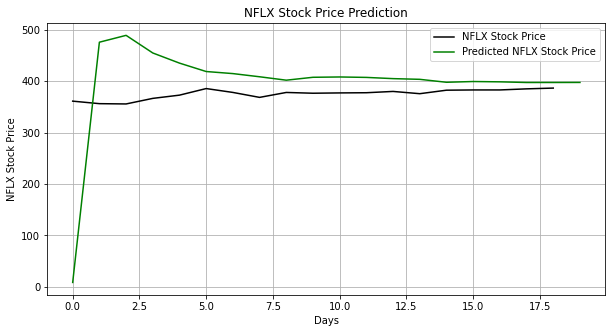

57.61281433507015
    Predicted Stock Price  Real Stock Price
0                8.441191           361.100
1              475.761017           356.210
2              489.077850           355.640
3              454.803467           366.480
4              435.082306           372.775
5              418.725861           385.580
6              414.696350           378.050
7              408.510986           368.430
8              401.876221           378.010
9              407.516754           376.500
10             408.124786           377.110
11             407.285339           377.480
12             404.900726           380.000
13             403.535919           375.600
14             397.821136           382.400
15             399.279846           382.880
16             398.662292           382.900
17             397.368805           385.000
18             397.393036           386.500
19             397.489777               NaN


In [42]:
# Visualising the results
plt.plot(real_stock_price, color = 'black', label = 'NFLX Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted NFLX Stock Price')
#make the plot look better
plt.rcParams['figure.figsize'] = [10, 5]
plt.grid(True)
plt.title('NFLX Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('NFLX Stock Price')
plt.legend()
plt.show()

# convert the results to a dataframe
result_df = pd.DataFrame(predicted_stock_price, columns=['Predicted Stock Price'])

#convert the real stock price to a dataframe
real_stock_price_df = pd.DataFrame(real_stock_price, columns=['Real Stock Price'])

#calculate the average error of the prediction
error = 0
for i in range(0, len(real_stock_price_df) -1 ):
    error += abs(real_stock_price_df.iloc[i,0] - result_df.iloc[i,0])
error = error / len(real_stock_price_df)
print(error)

df3 = pd.concat([result_df, real_stock_price_df], axis=1)
print(df3)